In [1]:
from glob import iglob
import pandas as pd
import re
import numpy as np

data = pd.DataFrame(columns=["article_id", "article", "propaganda"])

for path in iglob("../Data/datasets-v5/tasks-2-3/train/*"):
    file_name = path.split("/")[-1]
    extensions = file_name.split(".")
    article_id = re.search("article([0-9]+)", extensions[0]).group(1)
    if article_id not in data.article_id.values:
        data = data.append({"article_id" : article_id , "article" : '', "propaganda" : ''}, ignore_index=True)
    if extensions[1] == "txt":
        with open(path, 'r') as f:
            data.loc[data.article_id == article_id, 'article'] = f.read()
    elif extensions[1] == "task2":
        with open(path, 'r') as f:
            data.loc[data.article_id == article_id, 'propaganda'] = f.read()


In [15]:
clean_data = pd.DataFrame(columns=["article_id", "article", "propaganda"])

def clean_up(row):
    res = []
    a_id = row[0]
    art = row[1].split("\n")
    prop = row[2].split("\n")
    for record in prop:
        if record == '':
            continue
        element = []
        propaganda_type = record.split("\t")
        sentence = art[int(propaganda_type[1])-1]
        if sentence == '':
            continue
        element.append(a_id)
        element.append(sentence)
        element.append(propaganda_type[2])
        res.append(element)
    res = pd.DataFrame(res, columns=["article_id", "article", "propaganda"])
    return res
    
sentence_data = data.apply(clean_up, axis=1)

for s in sentence_data:
    clean_data = clean_data.append(s, ignore_index=True)
    
clean_data.head(10)

,article_id,article,propaganda
0,788173482,Exposing the Deep State Plotters,propaganda
1,788173482,President Trump’s sweeping order this week dir...,non-propaganda
2,788173482,"In an interview with Hill.TV yesterday, the pr...",propaganda
3,788173482,“What we’ve done is a great service to the cou...,propaganda
4,788173482,"“I hope to be able to call this, along with ta...",propaganda
5,788173482,Trump criticized how the FBI handled the Russi...,non-propaganda
6,788173482,“They know this is one of the great scandals i...,propaganda
7,788173482,They used Carter Page as a foil in order to su...,propaganda
8,788173482,"“It’s a hoax, beyond a witch hunt,” Trump said.",propaganda
9,788173482,The documents affected involve a FISA warrant ...,propaganda


In [16]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from textblob import TextBlob


#import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

def clean_stop_words(row):
    sentence = row["article"]
    tokenizer = RegexpTokenizer(r'\w+')
    stop_words = set(stopwords.words('english'))
    word_tokens = tokenizer.tokenize(sentence)
    tokens = [word_token for word_token in word_tokens if not word_token in stop_words]
    return tokens

def exclamations_count(row):
    words = row["tokens"]
    with open("exclamations.txt", "r", encoding='utf-8') as f:
        exclamations = [line.rstrip('\n') for line in f.readlines()]
    counts = [words.count(exclamation) for exclamation in exclamations]
    return counts

def has_plural_pronoun(row):
    sentence = row["article"]
    tokens = word_tokenize(sentence)
    tagged = pos_tag(tokens)
    pronouns = [tup for tup in tagged if tup[1] == 'NNPS']
    pronouns_len = len(pronouns)
    if pronouns_len == 0:
        return [0]
    return [1]

def has_singular_pronoun(row):
    sentence = row["article"]
    tokens = word_tokenize(sentence)
    tagged = pos_tag(tokens)
    pronouns = [tup for tup in tagged if tup[1] == 'NNP']
    pronouns_len = len(pronouns)
    if pronouns_len == 0:
        return [0]
    return [1]

def loaded_language(row):
    sentence = row["article"]
    with open("loaded_language_phrases.txt", "r", encoding="utf-8") as f:
        phrases = [line.rstrip('\n') for line in f.readlines()]
    return [sum([sentence.lower().count(phrase) for phrase in phrases])]

def confusing_words(row):
    sentence = row["article"]
    tokens = word_tokenize(sentence)
    words_tagged = pos_tag(tokens)
    # 0 - verbs, 1 - adjectives, 2 - nouns, 3 - adverbs
    word_vector = [0,0,0,0]
    for word, tag in words_tagged:
        if (tag.startswith('VB')):
            word_vector[0] += len(wordnet.synsets(word, pos=wordnet.VERB))
        elif (tag.startswith('JJ')):
            word_vector[1] += len(wordnet.synsets(word, pos=wordnet.ADJ))
        elif (tag.startswith('NN')):
            word_vector[2] += len(wordnet.synsets(word, pos=wordnet.NOUN))
        elif (tag.startswith('RB')):
            word_vector[3] += len(wordnet.synsets(word, pos=wordnet.ADV))
    transformed = list(map(lambda x:x/len(words_tagged),word_vector))
    return transformed

def polarity(row):
    sentence = row["article"]
    return [TextBlob(sentence).sentiment.polarity]


In [17]:
clean_data["tokens"] = clean_data.apply(clean_stop_words, axis=1)
clean_data["exclamation_counts"] = clean_data.apply(exclamations_count, axis=1)
clean_data["has_plural_pronoun"] = clean_data.apply(has_plural_pronoun, axis=1)
clean_data["has_singular_pronoun"] = clean_data.apply(has_singular_pronoun, axis=1)
clean_data["loaded_language"] = clean_data.apply(loaded_language, axis=1)
clean_data["confusing_words"] = clean_data.apply(confusing_words, axis=1)
clean_data["polarity"] = clean_data.apply(polarity, axis=1)
clean_data


,article_id,article,propaganda,tokens,exclamation_counts,has_plural_pronoun,has_singular_pronoun,loaded_language,confusing_words,polarity
0,788173482,Exposing the Deep State Plotters,propaganda,"[Exposing, Deep, State, Plotters]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[0],[1],[0],"[1.8, 0.0, 3.0, 0.0]",[0.0]
1,788173482,President Trump’s sweeping order this week dir...,non-propaganda,"[President, Trump, sweeping, order, week, dire...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[0],[1],[0],"[0.7608695652173914, 0.13043478260869565, 1.78...",[0.22000000000000003]
2,788173482,"In an interview with Hill.TV yesterday, the pr...",propaganda,"[In, interview, Hill, TV, yesterday, president...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[0],[1],[1],"[1.4705882352941178, 0.0, 0.6666666666666666, ...",[0.0]
3,788173482,“What we’ve done is a great service to the cou...,propaganda,"[What, done, great, service, country, really, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[0],[0],[0],"[1.85, 0.3, 1.0, 0.2]",[0.5]
4,788173482,"“I hope to be able to call this, along with ta...",propaganda,"[I, hope, able, call, along, tax, cuts, regula...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[0],[0],[2],"[1.7073170731707317, 0.34146341463414637, 1.56...",[0.3]
...,...,...,...,...,...,...,...,...,...,...
14258,7383612089,"Even more troubling, she “had run a secret pri...",propaganda,"[Even, troubling, run, secret, prison, Thailan...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[0],[1],[2],"[1.7014925373134329, 0.582089552238806, 0.8358...",[-0.12395833333333334]
14259,7383612089,"Beyond all that, she played a vital role in th...",non-propaganda,"[Beyond, played, vital, role, destruction, int...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[0],[0],[1],"[2.588235294117647, 0.9705882352941176, 0.9117...",[-0.14791666666666667]
14260,7383612089,"The concealment of those interrogation tapes, ...",non-propaganda,"[The, concealment, interrogation, tapes, viola...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[0],[1],[0],"[0.5681818181818182, 0.022727272727272728, 2.6...",[0.0]
14261,7383612089,A special prosecutor and grand jury investigat...,non-propaganda,"[A, special, prosecutor, grand, jury, investig...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[0],[0],[0],"[0.5, 0.9375, 0.8125, 0.125]",[0.28571428571428575]


In [18]:
from sklearn.model_selection import train_test_split

all_cols = clean_data.columns.tolist()
label_col = ["propaganda"]
exclude = ["article_id", "tokens"]
feature_cols = list(set(all_cols) - set(label_col) - set(exclude))

train_data = clean_data[feature_cols]
train_target = clean_data[label_col]

class_to_number_dict = {
    'propaganda':0,
    'non-propaganda':1
}

X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, test_size=0.20, stratify=train_target)

y_train = y_train.replace({"propaganda": class_to_number_dict})
y_test = y_test.replace({"propaganda": class_to_number_dict})


In [19]:
X_train

,has_singular_pronoun,polarity,has_plural_pronoun,article,loaded_language,exclamation_counts,confusing_words
1517,[1],[0.21428571428571427],[0],Trump seemed certain he could somehow cajole C...,[1],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.4117647058823529, 0.6470588235294118, 1.058..."
5250,[1],[3.700743415417188e-17],[0],"Now, some say the Council is (was) good, but o...",[1],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.6315789473684212, 1.8421052631578947, 0.315..."
6187,[1],[0.0],[0],Because of this schizophrenic mindset of the C...,[0],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.3636363636363635, 0.45454545454545453, 1.18..."
6207,[0],[0.0],[0],take our poll - story continues below,[0],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[7.428571428571429, 0.0, 1.5714285714285714, 0.0]"
4120,[1],[0.15000000000000002],[0],The bullet ricocheted on the pier’s concrete w...,[0],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.0555555555555554, 0.1111111111111111, 0.388..."
...,...,...,...,...,...,...,...
9095,[1],[-0.09999999999999999],[0],"Late Thursday, Sen. Charles E. Grassley (R-Iow...",[0],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.75, 0.0625, 1.3125, 0.14583333333333334]"
5208,[1],[0.0],[0],The Instructions said the infiltration will ta...,[0],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.409090909090909, 0.045454545454545456, 0.90..."
14217,[1],[0.1],[0],Florida law already mandates a three-day waiti...,[0],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.4, 0.16666666666666666, 1.0666666666666667,..."
488,[1],[-0.3],[0],"He knew from at least June 23, 2013 that McCar...",[0],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.5, 0.3125, 0.1875, 0.0]"


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

ps = PorterStemmer()
def my_tokenizer(str_input):
    str_input = str_input.replace("!"," exclamationsign")
    str_input = str_input.replace("?"," questionmark")
    tokens = str_input.split()
    words = [ps.stem(token) for token in tokens if token not in stopwords.words('english')]
    return words

tfidf_vectorizer = TfidfVectorizer(stop_words='english',lowercase=True,min_df = 3, max_df=0.8,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1)

X_train_features = tfidf_vectorizer.fit_transform(X_train["article"])
X_test_features = tfidf_vectorizer.transform(X_test["article"])


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/prathiksharprasad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
XX_train = np.hstack([X_train["exclamation_counts"].tolist(), \
                                X_train["has_plural_pronoun"].tolist(), \
                                X_train["has_singular_pronoun"].tolist(), \
                                X_train["loaded_language"].tolist(), \
                                X_train["confusing_words"].tolist(), \
                                X_train["polarity"].tolist(), \
                                list(X_train_features.toarray())])

In [31]:
XX_test = np.hstack((X_test["exclamation_counts"].tolist(), \
                                X_test["has_plural_pronoun"].tolist(), \
                                X_test["has_singular_pronoun"].tolist(), \
                                X_test["loaded_language"].tolist(), \
                                X_test["confusing_words"].tolist(), \
                                X_test["polarity"].tolist(), \
                                list(X_test_features.toarray())))

## Function to plot confusion matrix

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn import metrics

# scaler = StandardScaler(with_mean=True, with_std=True)
# X_train_features = scaler.fit_transform(XX_train)
# X_test_features = scaler.transform(XX_test)

clf = LogisticRegression(solver="liblinear")
clf.fit(XX_train, y_train["propaganda"])
y_pred = clf.predict(XX_test)

print("F1 Score", f1_score(y_test, y_pred, average="weighted"))
print("Accuracy Score", metrics.accuracy_score(y_test, y_pred))

F1 Score 0.7254717654477073
Accuracy Score 0.7665615141955836


Confusion matrix, without normalization
[[ 207  581]
 [  85 1980]]
Normalized confusion matrix
[[0.26 0.74]
 [0.04 0.96]]


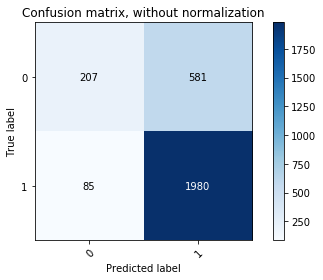

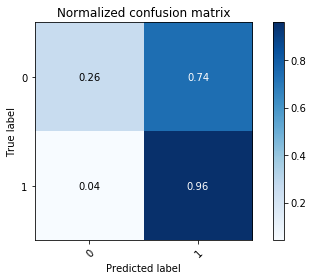

In [43]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array([0, 1]),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array([0, 1]), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Passive Aggressive Classifier

In [48]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn import metrics

linear_clf = PassiveAggressiveClassifier(max_iter=2000)
linear_clf.fit(XX_train, y_train["propaganda"])
y_pred = linear_clf.predict(XX_test)

print("F1 Score", f1_score(y_test, y_pred, average="weighted"))
print("Accuracy Score", metrics.accuracy_score(y_test, y_pred))


F1 Score 0.7214236062088618
Accuracy Score 0.7164388363126534


Confusion matrix, without normalization
[[ 434  354]
 [ 455 1610]]
Normalized confusion matrix
[[0.55 0.45]
 [0.22 0.78]]


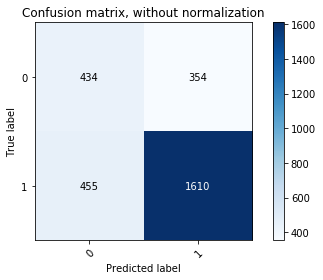

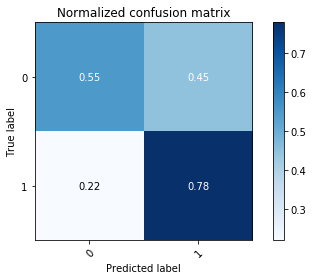

In [49]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array([0, 1]),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array([0, 1]), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## LSTM

In [50]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, GlobalMaxPool1D, Dense, Dropout, Conv1D

embed_size = 200
max_features = 6000

model = Sequential()
model.add(Embedding(max_features, embed_size))
model.add(Conv1D(100,3,padding='valid',strides=1))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         1200000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 100)         60100     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2020      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 1,262,141
Trainable params: 1,262,141
Non-trainable params: 0
____________________________________________

In [51]:
all_cols = clean_data.columns.tolist()
label_col = ["propaganda"]
feature_cols = ["article"]

train_data = clean_data[feature_cols]
train_target = clean_data[label_col]

LX_train, LX_test, Ly_train, Ly_test = train_test_split(train_data, train_target, test_size=0.20, stratify=train_target)

Ly_train = Ly_train.replace({"propaganda": class_to_number_dict})
Ly_test = Ly_test.replace({"propaganda": class_to_number_dict})

In [52]:
max_features = 6000
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(LX_train["article"])

df_dev_x_tokens = tokenizer.texts_to_sequences(LX_train["article"])
df_val_x_tokens = tokenizer.texts_to_sequences(LX_test["article"])

In [53]:
max_sequence_length=500
df_dev_x_pad = pad_sequences(df_dev_x_tokens, maxlen=max_sequence_length)
df_val_x_pad = pad_sequences(df_val_x_tokens, maxlen=max_sequence_length)


In [54]:
model.fit(df_dev_x_pad, Ly_train, batch_size=128, epochs=10)

/Users/prathiksharprasad/anaconda3/envs/cs676/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
11410/11410 [==============================] - 45s 4ms/step - loss: 0.5803 - accuracy: 0.7193
Epoch 2/10
11410/11410 [==============================] - 44s 4ms/step - loss: 0.4622 - accuracy: 0.7771
Epoch 3/10
11410/11410 [==============================] - 44s 4ms/step - loss: 0.3156 - accuracy: 0.8703
Epoch 4/10
11410/11410 [==============================] - 45s 4ms/step - loss: 0.1808 - accuracy: 0.9379
Epoch 5/10
11410/11410 [==============================] - 44s 4ms/step - loss: 0.0886 - accuracy: 0.9760
Epoch 6/10
11410/11410 [==============================] - 45s 4ms/step - loss: 0.0569 - accuracy: 0.9865
Epoch 7/10
11410/11410 [==============================] - 43s 4ms/step - loss: 0.0479 - accuracy: 0.9886
Epoch 8/10
11410/11410 [==============================] - 44s 4ms/step - loss: 0.0373 - accuracy: 0.9908
Epoch 9/10
11410/11410 [==============================] - 44s 4ms/step - loss: 0.0347 - accuracy: 0.9911
Epoch 10/10
11410/11410 [==============================

In [55]:
df_val_y_pred = model.predict(df_val_x_pad, verbose=1).round()

print("F1 Score", f1_score(Ly_test, df_val_y_pred, average="weighted"))
print("Accuracy Score", metrics.accuracy_score(Ly_test, df_val_y_pred))


2853/2853 [==============================] - 4s 1ms/step
F1 Score 0.7322250349435803
Accuracy Score 0.7462320364528566


Confusion matrix, without normalization
[[ 317  471]
 [ 253 1812]]
Normalized confusion matrix
[[0.4  0.6 ]
 [0.12 0.88]]


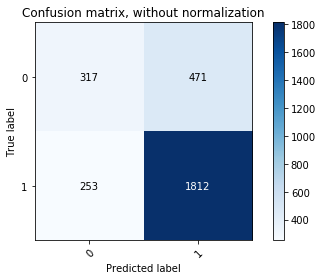

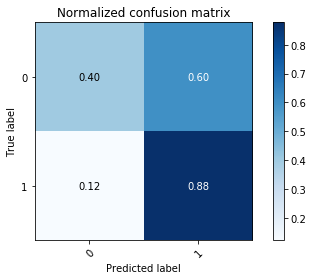

In [56]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(Ly_test, df_val_y_pred, classes=np.array([0, 1]),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Ly_test, df_val_y_pred, classes=np.array([0, 1]), normalize=True,
                      title='Normalized confusion matrix')

plt.show()